<a href="https://colab.research.google.com/github/charlieh-hub/coursera_deeplearning/blob/main/marble_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import numpy as np                  # For numerical operations
import tensorflow as tf            # Main TensorFlow library
from tensorflow import keras       # High-level neural network API
from keras import layers           # Neural network layer components
from matplotlib import pyplot as plt  # For plotting and visualization
from keras import ops                 # For tensor operations in Keras
import tensorflow_datasets as tfds
import h5py
import os

In [2]:
tf.keras.backend.clear_session()

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

train_dataset_h5 = h5py.File(os.path.join('/content/drive/My Drive/','train_marbles_yolo_classification.h5'), "r")
dev_dataset_h5 = h5py.File(os.path.join('/content/drive/My Drive/','dev_marbles_yolo_classification.h5'), "r")
test_dataset_h5 = h5py.File(os.path.join('/content/drive/My Drive/','test_marbles_yolo_classification.h5'), "r")

x_train = train_dataset_h5['train_set_x'][:]
y_train = train_dataset_h5['train_set_y'][:]

x_dev = dev_dataset_h5['dev_set_x'][:]
y_dev = dev_dataset_h5['dev_set_y'][:]

x_test = test_dataset_h5['test_set_x'][:]
y_test = test_dataset_h5['test_set_y'][:]

print(f"x_train shape: {x_train.shape}")
print(f"x_train type: {x_train.dtype}")

print(f"x_dev shape: {x_dev.shape}")
print(f"x_dev type: {x_dev.dtype}")

print(f"x_test shape: {x_test.shape}")
print(f"x_test type: {x_test.dtype}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {y_test.dtype}")


Mounted at /content/drive
x_train shape: (1223, 224, 224, 3)
x_train type: uint8
x_dev shape: (153, 224, 224, 3)
x_dev type: uint8
x_test shape: (153, 224, 224, 3)
x_test type: uint8
y_test shape: (153, 5)
y_test type: uint8


In [4]:
# Classes as dictionary
classes_bytes = train_dataset_h5['list_classes'][:]
classes = [class_name.decode('utf-8') for class_name in classes_bytes]
assert len(classes) == 5

# Reshape images to (32, 32, 3) and pixel values to range [-1.0, 1.0]
x_train = x_train.reshape(-1, 224, 224, 3).astype('float32') / 127.5 - 1.0
x_dev = x_dev.reshape(-1, 224, 224, 3).astype('float32') / 127.5 - 1.0
x_test = x_test.reshape(-1, 224, 224, 3).astype('float32') / 127.5 - 1.0


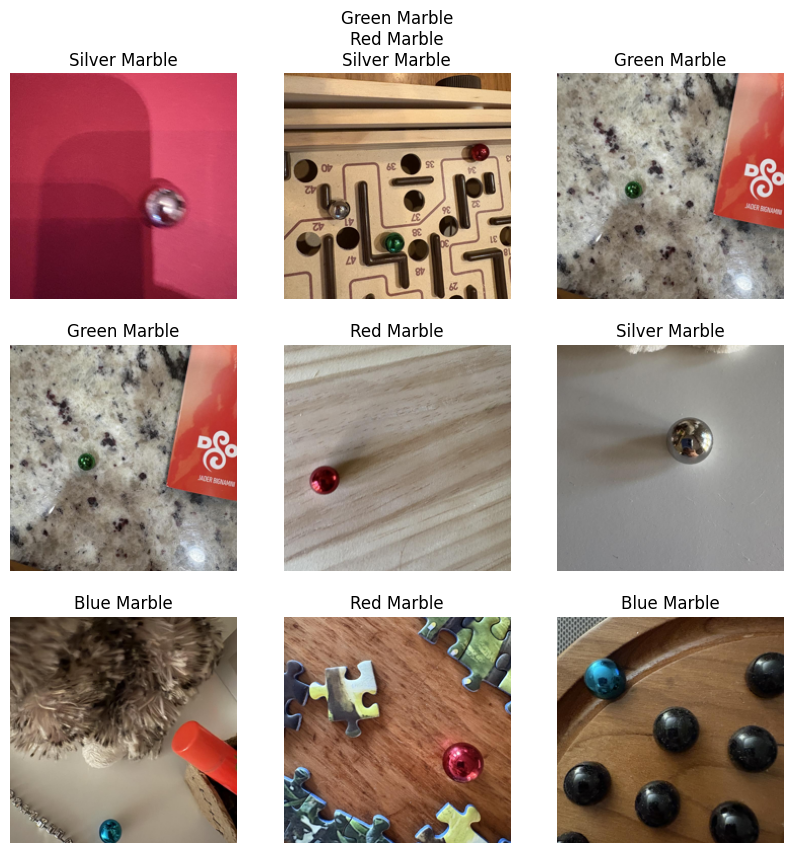

In [5]:
# Display some sample images from the MNIST dataset
random_indices = np.random.randint(0, x_train.shape[0], size=9)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((x_train[idx].squeeze() + 1.0) / 2.0)
    indices = tf.where(y_train[idx] == 1).numpy().flatten()
    if len(indices) > 0:
        plt.title('\n'.join(classes[idx] for idx in indices))
    else:
        plt.title("No class found")
    plt.axis("off")


In [6]:
# MobileNetV3Large = 93.3%
# EfficientNetV2S = 95.6%
# EfficientNetV2M = 96.9%
# EfficientNetV2L = 98.6%
# InceptionResNetV2 = 95.2%
# ResNet50V2 = 89.5%
# ConvNeXtSmall = 96.0%
# ConvNeXtLarge = 98.0%
# DenseNet201 = 97.0% - try fine-tuning more layers
# EfficientNetB7 = 85.7%

base_model = tf.keras.applications.DenseNet201(
    include_top=False,  # Include classification layers
    weights='imagenet',  # Use pre-trained weights
    pooling='avg',
    # include_preprocessing=False
)


base_model.trainable = False  # Freeze base model weights

# base_model.summary()

# Define model layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid')

# Data augmentation layers (currently disabled)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    # tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    # tf.keras.layers.RandomContrast(0.05),
    # tf.keras.layers.RandomBrightness(0.05),
    # tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomFlip('vertical'),
])

# Build the model
inputs = tf.keras.Input(shape=(224, 224, 3))  # Original CIFAR10 image size
# x = tf.keras.layers.Resizing(height=224, width=224)(inputs)  # Resize to match MobileNetV3
x = data_augmentation(inputs)  # Apply data augmentation
x = base_model(x, training=False)  # Pass through base model
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
outputs = prediction_layer(x)  # Final classification layer

# Create the full model
model = tf.keras.Model(inputs, outputs)

model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         9,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,331,589 (69.93 MB)

 Trainable params: 9,605 (37.52 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(from_logits=True, name="loss"),
    # Calculates how often predictions match integer labels
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

In [8]:
initial_epochs = 20

history = model.fit(x_train, y_train, epochs=initial_epochs, batch_size=32, validation_data=(x_dev, y_dev))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 569ms/step - accuracy: 0.6456 - loss: 0.7067 - val_accuracy: 0.7490 - val_loss: 0.4992
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.7237 - loss: 0.5484 - val_accuracy: 0.7817 - val_loss: 0.4496
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.7536 - loss: 0.4933 - val_accuracy: 0.7935 - val_loss: 0.4178
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.7864 - loss: 0.4501 - val_accuracy: 0.8118 - val_loss: 0.3916
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.7945 - loss: 0.4315 - val_accuracy: 0.8405 - val_loss: 0.3768
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.8046 - loss: 0.4125 - val_accuracy: 0.8261 - val_loss: 0.3632
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.8122 - loss: 0.3993 - val_accuracy: 0.8261 - val_loss: 0.3575
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.8410 - loss: 0.3631 - val_accuracy: 0.8353 - 

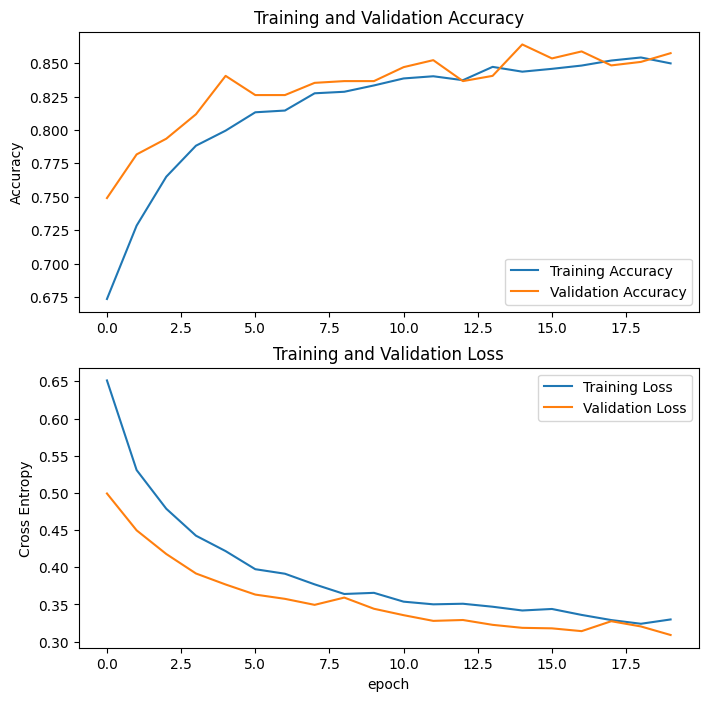

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", loss)
print("Test error:", (1 - accuracy)*100, "%")

5/5 - 1s - 210ms/step - accuracy: 0.9020 - loss: 0.2641
Test loss: 0.2640760838985443
Test error: 9.803920984268188 %


In [11]:
base_model.trainable = True

# Train only last two blocks
for layer in base_model.layers:
    if 'conv0' in layer.name or 'conv1' in layer.name or 'conv2' in layer.name or 'conv3' in layer.name:
        layer.trainable = False

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False



In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, weight_decay=0.0001),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(from_logits=True, name="loss"),
    # Calculates how often predictions match integer labels
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

In [13]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit(x_train, y_train, epochs=total_epochs,
                    initial_epoch=len(history.epoch), batch_size=32, validation_data=(x_dev, y_dev))

Epoch 21/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7868 - loss: 0.4686 - val_accuracy: 0.8693 - val_loss: 0.2874
Epoch 22/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step - accuracy: 0.8343 - loss: 0.3614 - val_accuracy: 0.8876 - val_loss: 0.2682
Epoch 23/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 773ms/step - accuracy: 0.8625 - loss: 0.2980 - val_accuracy: 0.8941 - val_loss: 0.2476
Epoch 24/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step - accuracy: 0.8765 - loss: 0.2757 - val_accuracy: 0.9059 - val_loss: 0.2255
Epoch 25/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 771ms/step - accuracy: 0.8945 - loss: 0.2510 - val_accuracy: 0.9163 - val_loss: 0.2023
Epoch 26/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 782ms/step - accuracy: 0.9057 - loss: 0.2214 - val_accuracy: 0.9216 - val_loss: 0.1870
Epoch 27/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 776ms/step - accuracy: 0.9213 - loss: 0.1933 - val_accuracy: 0.9320 - val_loss: 0.1701
Epoch 28/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 773ms/step - accuracy: 0.9280 - loss: 0.1814 - va

In [14]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


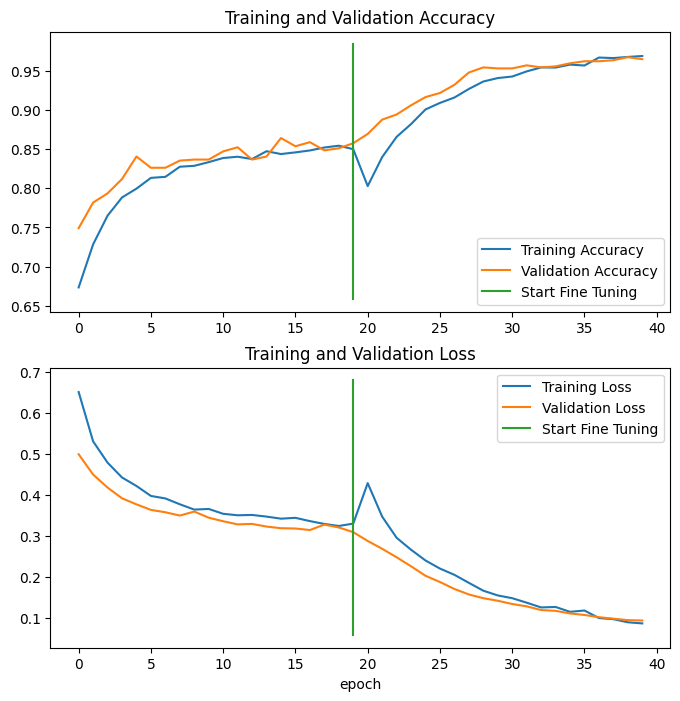

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", loss)
print("Test error:", (1 - accuracy)*100, "%")

5/5 - 1s - 234ms/step - accuracy: 0.9804 - loss: 0.0621
Test loss: 0.062113262712955475
Test error: 1.9607841968536377 %


In [17]:
model.save("my_model.keras")

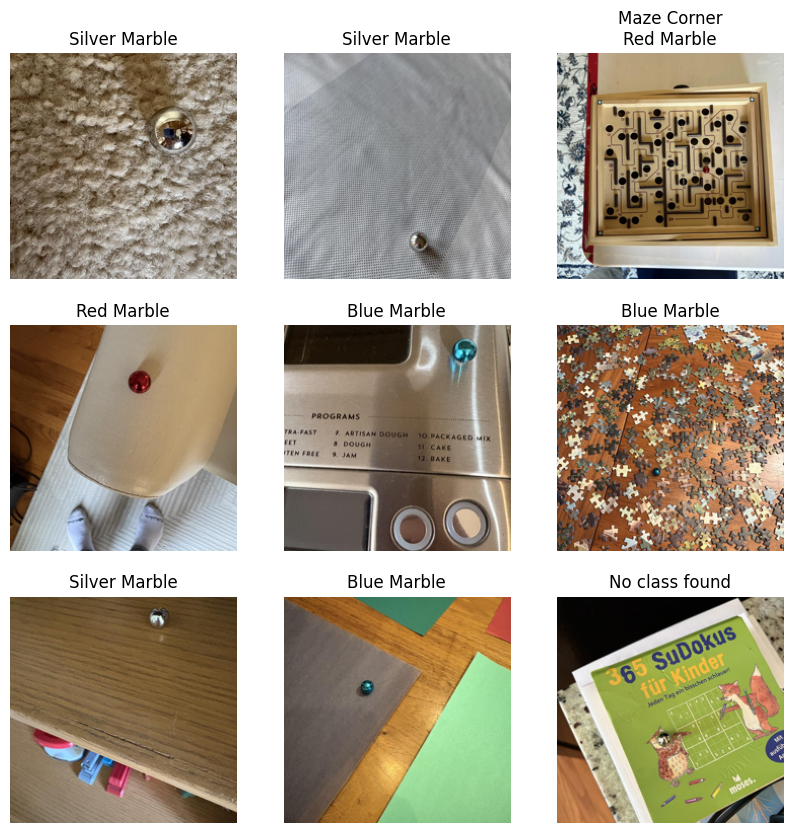

In [23]:
# Retrieve a batch of images from the test set
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=10000).batch(2048)
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.reshape(predictions, (-1, 5))
predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((image_batch[i] + 1.0) / 2.0)
  indices = tf.where(predictions[i] == 1).numpy().flatten()
  if len(indices) > 0:
      plt.title('\n'.join(classes[idx] for idx in indices))
  else:
      plt.title("No class found")
  plt.axis("off")



Number of examples: 153
Number of misclassified examples: 14


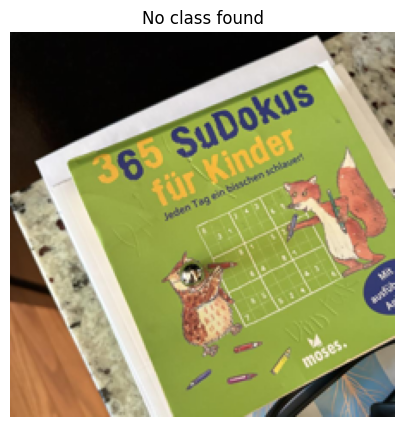

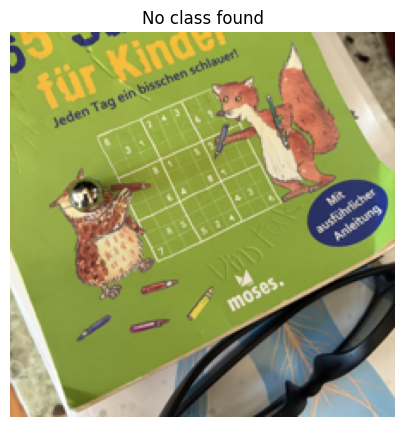

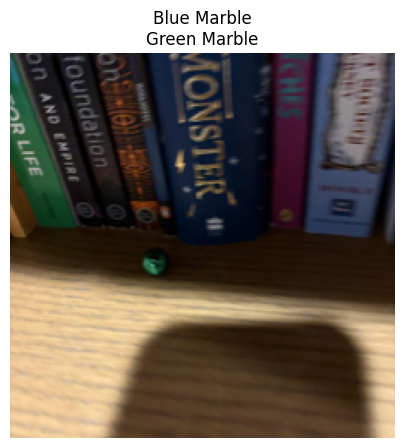

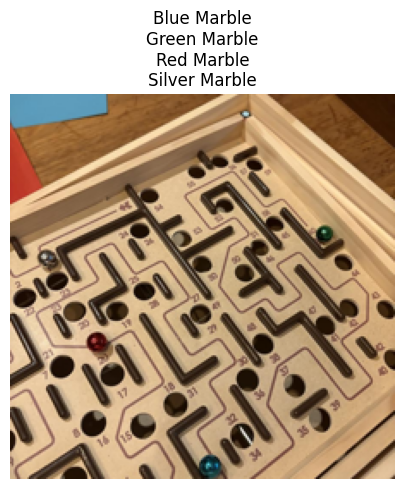

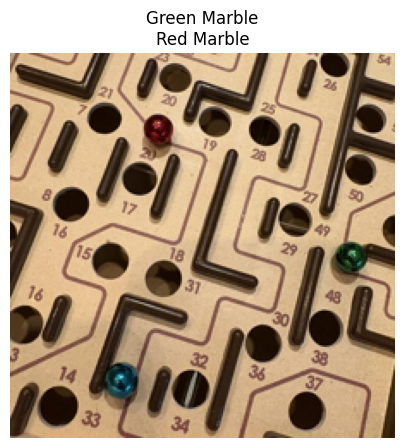

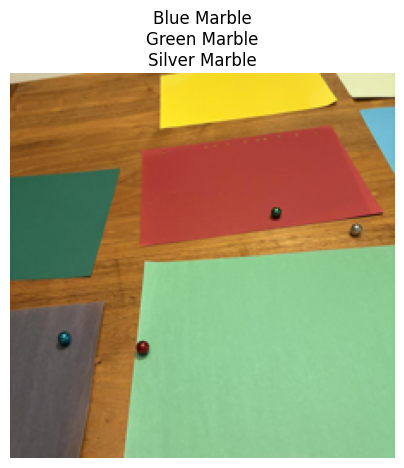

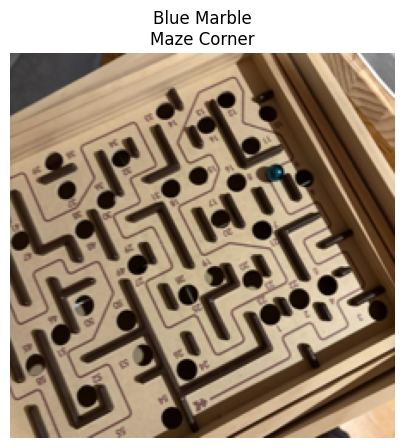

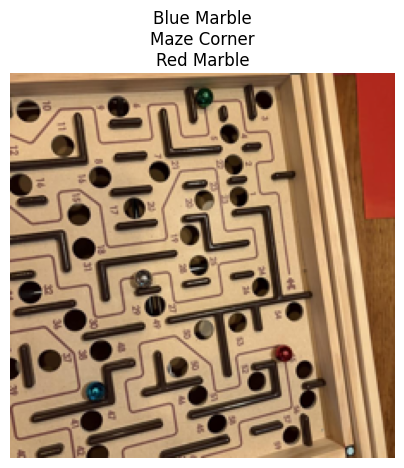

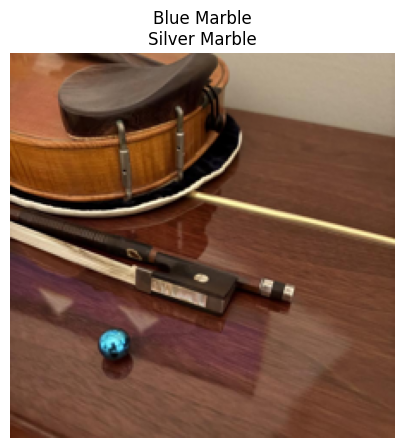

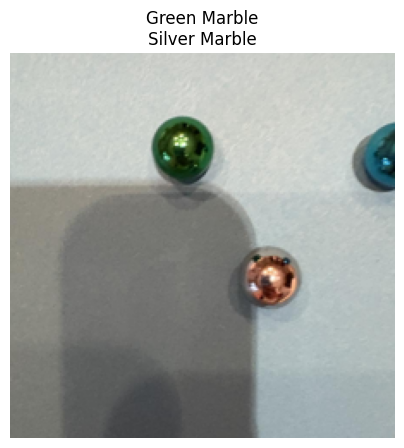

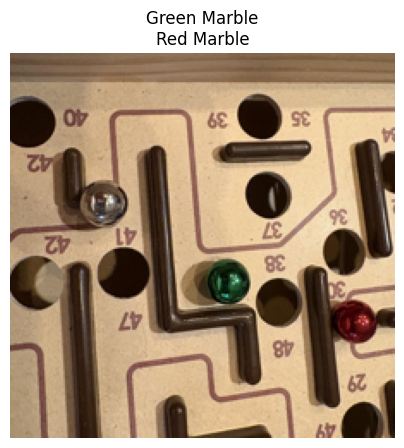

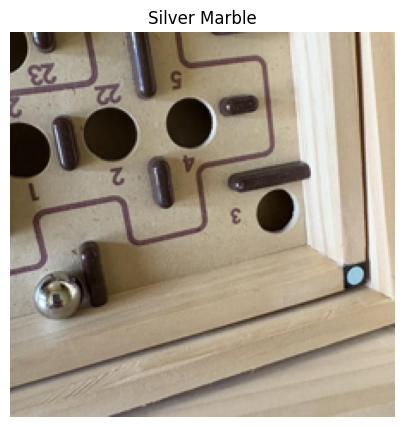

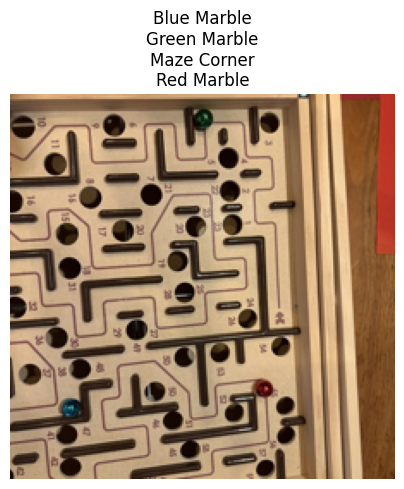

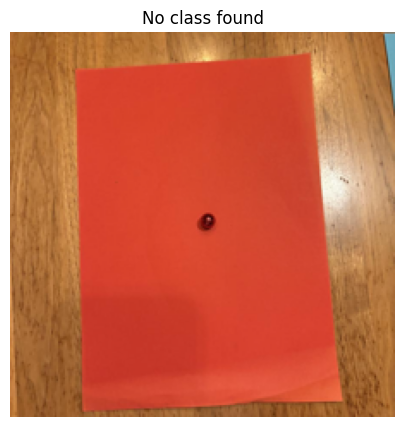

In [24]:
# Check example images that were misclassified
class_accuracy = (predictions.numpy().astype(int) == label_batch).all(axis=1)

print(f"Number of examples: {len(class_accuracy)}")
print(f"Number of misclassified examples: {len(class_accuracy[class_accuracy == False])}")

for i, correct in enumerate(class_accuracy):
  if not correct:
    plt.figure(figsize=(5, 5))
    plt.imshow((image_batch[i] + 1.0) / 2.0)
    indices = tf.where(predictions[i] == 1).numpy().flatten()
    if len(indices) > 0:
        plt.title('\n'.join(classes[idx] for idx in indices))
    else:
        plt.title("No class found")
    plt.axis("off")


Number of correctly classified examples: 139


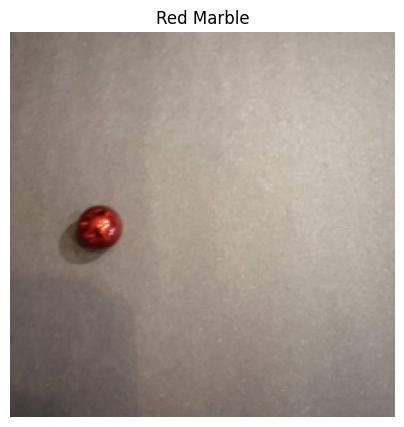

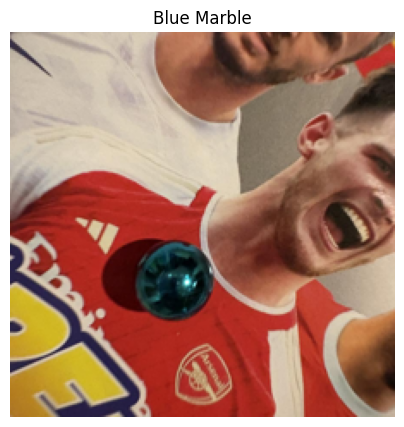

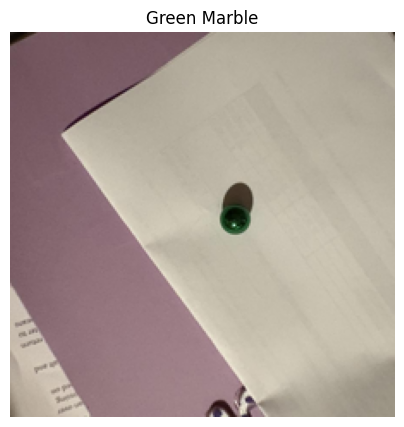

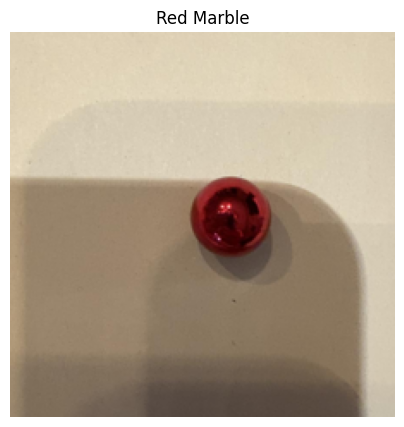

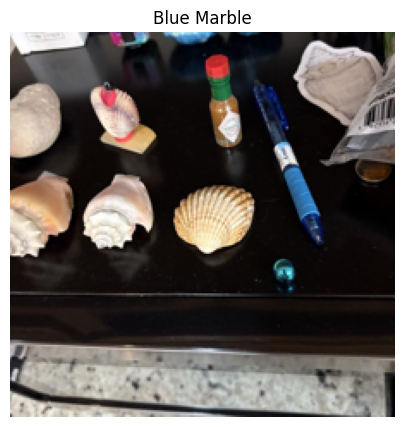

In [20]:
# Check example images that were sclassified correctly

print(f"Number of correctly classified examples: {len(class_accuracy[class_accuracy == True])}")

for i, correct in enumerate(class_accuracy):
  if correct and (i < 5):
    plt.figure(figsize=(5, 5))
    plt.imshow((image_batch[i] + 1.0) / 2.0)
    indices = tf.where(predictions[i] == 1).numpy().flatten()
    if len(indices) > 0:
        plt.title('\n'.join(classes[idx] for idx in indices))
    else:
        plt.title("No class found")
    plt.axis("off")